In [29]:
import pandas as pd
from PIL import Image,ImageDraw,ImageFont
import os
import numpy as np
import math

In [30]:
feature_table = pd.read_csv("193398_feattable.csv")

In [31]:
feature_table.sort_values(by="feature_importance",inplace=True)
feature_table.reset_index(drop=True,inplace=True)

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt

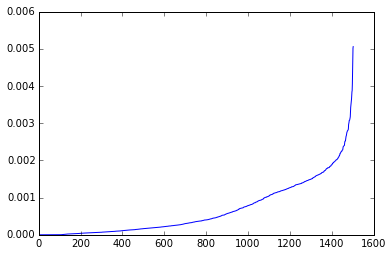

In [33]:
fig,ax = plt.subplots()
ax.plot(feature_table.index,feature_table.feature_importance)

In [34]:
ii = pd.read_csv("193398_individual_importances.csv")

In [35]:
#feature_table = feature_table[feature_table.feature_importance>0.00305]
#feature_table.reset_index(drop=True,inplace=True)
top_feats = list(feature_table.feature)

In [36]:
len(top_feats)

1504

In [37]:
#top_feats

In [38]:
botfeats = feature_table.sort_values(by="feature_importance").feature[:5]

#### train matrix

In [39]:
train_matrix = pd.read_csv("193398_train.csv")
labels = train_matrix.outcome
#del train_matrix['outcome']

In [40]:
train_matrix = train_matrix[train_matrix['ocag_id_all_officerage_max']!=0]

In [41]:
train_matrix.outcome.value_counts()

0    15256
1     1531
Name: outcome, dtype: int64

In [42]:
tmp = train_matrix[['ocag_id_all_officerage_max','outcome']]

In [43]:
prior = float(1531)/15256

In [44]:
max(tmp.ocag_id_all_officerage_max) - min(tmp.ocag_id_all_officerage_max)

46.0

In [45]:
min(tmp.ocag_id_all_officerage_max)

21.0

In [46]:
ages = np.arange(21,68)
ages

array([21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
       38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67])

In [47]:
agelabels = np.arange(21,68,3)
print len(agelabels)

16


## Binning

In [48]:
def binticks_label(matrix,feat):
    tmp = matrix.loc[:,feat]
    tmpmin = min(tmp)
    tmpmax = max(tmp)
    tmprange = tmpmax - tmpmin
    step = tmprange / 100
    return np.arange(tmpmin,tmpmax+step,step)

In [49]:
def labelticks(matrix,feat):
    tmp = matrix.loc[:,feat]
    tmpmin = min(tmp)
    tmpmax = max(tmp)
    tmprange = tmpmax - tmpmin
    step = tmprange / 20
    return np.arange(tmpmin,tmpmax+step,step)

In [50]:
def minmax_label(matrix,feat):
    tmp = matrix.loc[:,feat]
    tmpmin = min(tmp)
    tmpmax = max(tmp)
    return tmpmin,tmpmax

### Axis labels

In [89]:
def addlabels(canvas,ticks):
    width = canvas.width
    height = canvas.height
    margin = rectheight
    newheight = height + margin
    
    unicanvas = Image.new('RGB',(width,newheight),(255,255,255))
    unicanvas.paste(canvas,(0,0))
    
    font = ImageFont.truetype('VeraMono.ttf', rectheight - 16 )
    
    # fontWidth, fontHeight = font.getsize(high) # can use if I have sizing issues

    draw = ImageDraw.Draw(unicanvas,'RGB')
    
    for i in range(len(ticks)):
        xpos = i * rectwidth * 3
        #xpos = i * rectwidth * 5
        draw.text((xpos,newheight - margin ),text=str(ticks[i]),font=font,fill=(0,0,0))
    
    return unicanvas

# Train plot

In [90]:
def updown(X,cfeat,rectwidth,rectheight,pad):
    #bins = binticks_label(train_matrix,cfeat) # note that this will give full-data bin edges regardless of subsetting
    bins = ages
    nbins = len(bins)
    pos = pd.cut(X[labels==1].loc[:,cfeat],bins=bins,labels=False,include_lowest=True)
    neg = pd.cut(X[labels==0].loc[:,cfeat],bins=bins,labels=False,include_lowest=True)
    px_w = ( nbins - 1 ) * rectwidth # a hack; won't work with all subsets
        
    ###########
    ### POS ###
    ###########
    
    posbinmax = pos.value_counts().max()
    ppx_h = posbinmax * rectheight
    
    up = Image.new('RGB',(px_w,ppx_h),(255,255,255))
    updraw = ImageDraw.Draw(up)
    
    for binn in range(nbins):
        xpos = binn * rectwidth
        ypos = ppx_h - rectheight

        tmp = pos[pos==binn]
        for i in tmp.index:
            bbox = [(xpos+pad,ypos+pad),(xpos+rectwidth-pad,ypos+rectheight-pad)]
            updraw.rectangle(bbox,fill='hsl(0,0%,50%)',outline=None)
            ypos = ypos - rectheight
        
        actual_positives = len(tmp)
        n = actual_positives + len(neg[neg==binn])
        expected_positives = int( n * float(prior) )
        lift = actual_positives - expected_positives
        
        if lift > 0:
            ypos = ppx_h - lift*rectheight
        else:
            ypos = ppx_h
            
        coords = [(xpos,ypos),(xpos+rectwidth,ypos)]
        #updraw.line(coords,fill=(220,101,113),width=6) # red
        
        try:
            coords = [(last_xpos+rectwidth,last_ypos),(xpos,ypos)]
            #updraw.line(coords,fill=(220,101,113),width=6)
        except:
            pass

        last_ypos = ypos
        last_xpos = xpos
        
        # lp draw boxes (instead of fill)
        ypos = ppx_h - rectheight # need to reset

        for i in range(lift):
            bbox = [(xpos+pad,ypos+pad),(xpos+rectwidth-pad,ypos+rectheight-pad)]
            #updraw.rectangle(bbox,fill=(220,101,113),outline=None)
            ypos = ypos - rectheight
        
        # lp fill
        #bbox = [(xpos+pad,ypos),(xpos+rectwidth-pad,ppx_h)]
        #updraw.rectangle(bbox,fill=(220,101,113),outline=None)
        
    #up = addlabels(up,labelticks(train_matrix,cfeat))
    up = addlabels(up,agelabels)
    
    ###########
    ### NEG ###
    ###########
    
    # reset for line thing
    last_ypos = None
    last_xpos = None
    
    negbinmax = neg.value_counts().max()
    
    npx_h = negbinmax * rectheight
    
    down = Image.new('RGB',(px_w,npx_h),(255,255,255))
    downdraw = ImageDraw.Draw(down)
    
    lifts = []
    for binn in range(nbins):
        xpos = binn * rectwidth
        ypos = npx_h - rectheight
                
        tmp = neg[neg==binn]
        for i in tmp.index:
            bbox = [(xpos+pad,ypos+pad),(xpos+rectwidth-pad,ypos+rectheight-pad)]
            downdraw.rectangle(bbox,fill='hsl(0,0%,75%)',outline=None)
            ypos = ypos - rectheight
               
        actual_positives = len(pos[pos==binn])
        n = actual_positives + len(tmp)
        expected_positives = int( n * float(prior) )
        lift = actual_positives - expected_positives
        lifts.append(lift)
                
        if lift < 0:
            ypos = npx_h - abs(lift)*rectheight
        else:
            ypos = npx_h
            
        coords = [(xpos,ypos),(xpos+rectwidth,ypos)]
        #downdraw.line(coords,fill=(112,159,210),width=6)
        
        try:
            coords = [(last_xpos+rectwidth,last_ypos),(xpos,ypos)]
            #downdraw.line(coords,fill=(112,159,210),width=6)
        except:
            pass
        
        last_ypos = ypos
        last_xpos = xpos
        
        # lp draw boxes 
        ypos = npx_h - rectheight

        if lift < 0: # this ensures only pulls are plotted on downdraw
            for i in range(abs(lift)):        
                bbox = [(xpos+pad,ypos+pad),(xpos+rectwidth-pad,ypos+rectheight-pad)]
                #downdraw.rectangle(bbox,fill=(112,159,210),outline=None)
                ypos = ypos - rectheight
        
        # lp fill
        #bbox = [(xpos+pad,ypos),(xpos+rectwidth-pad,npx_h)]
        #downdraw.rectangle(bbox,fill=(112,159,210),outline=None)
    
    unicanvas = up # eliminate down
    #unicanvas = Image.new('RGB',(px_w,up.height+npx_h),(255,255,255))
    #unicanvas.paste(up,(0,0))

    #down_flipped = down.transpose(Image.FLIP_TOP_BOTTOM)
    #unicanvas.paste(down_flipped,(0,up.height))

    return unicanvas,up.height,px_w,lifts

In [97]:
pad = 2

In [98]:
rectwidth = 56
rectheight = 56

### Interaction Binning

In [99]:
#ifeat = "arrests_id_p1y_arrestson_sat_avg"
cfeat = 'ocag_id_all_officerage_max'
#train_matrix['ifeat'] = pd.cut(train_matrix[ifeat],bins=3,labels=False,include_lowest=False)

In [100]:
#X = train_matrix[train_matrix.ifeat==1]

In [101]:
#len(X)

In [102]:
im,uph,px_w,lifts = updown(train_matrix,cfeat,rectwidth,rectheight,pad)
#lp_crop = [0,uph-(max(lifts)*rectheight+2*rectheight),px_w,uph+(abs(min(lifts))*rectheight+rectheight)]
#im = im.crop(lp_crop)
im.save("/Users/damoncrockett/Desktop/"+cfeat+".png")
#im.save("/Users/damoncrockett/Desktop/"+cfeat+"_"+ifeat+"bin2"+"_lp.png")

/Library/Python/2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Library/Python/2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [ ]:
#halfheight = 1575/2
#cropbox = [0,uph-halfheight,px_w,uph+halfheight]
#im = im.crop(cropbox)

In [ ]:
#im.save("/Users/damoncrockett/Desktop/tmpwintour/PILplatz/VASTvideo/"+cfeat+"linepos"+".png")